## Introduction

Previously I've shown how to create a [linear model and neural net from scratch](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch), and used it to create a solid submission to Kaggle's [Titanic](https://www.kaggle.com/competitions/titanic/) competition. However, for *tabular* data (i.e data that looks like spreadsheet or database tables, such as the data for the Titanic competition) it's more common to see good results by using ensembles of decision trees, such as Random Forests and Gradient Boosting Machines.

In this notebook, we're going to learn all about Random Forests, by building one from scratch, and using it to submit to the Titanic competition! That might sound like a pretty big stretch, but I think you'll be surprised to discover how straightforward it actually is.

We'll start by importing the basic set of libraries we normally need for data science work, and setting numpy to use our display space more efficiently:

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Data preprocessing

We'll create `DataFrame`s from the CSV files just like we did in the "*linear model and neural net from scratch*" notebook, and do much the same preprocessing (so go back and check that out if you're not already familiar with the dataset):

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


One difference with Random Forests however is that we don't generally have to create *dummy variables* like we did for non-numeric columns in the linear models and neural network. Instead, we can just convert those fields to *categorical variables*, which internally in Pandas makes a list of all the unique values in the column, and replaces each value with a number. The number is just an index for looking up the value in the list of all unique values.

In [57]:
print(modes)

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object


In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

We'll make a list of the continuous, categorical, and dependent variables. Note that we no longer consider `Pclass` a categorical variable. That's because it's *ordered* (i.e 1st, 2nd, and 3rd class have an order), and decision trees, as we'll see, only care about order, not about absolute value.

In [4]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

Even although we've made the `cats` columns categorical, they are still shown by Pandas as their original values:

In [5]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

However behind the scenes they're now stored as integers, with indices that are looked up in the `Categories` list shown in the output above. We can view the stored values by looking in the `cat.codes` attribute:

In [6]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

## Binary splits

Before we create a Random Forest or Gradient Boosting Machine, we'll first need to learn how to create a *decision tree*, from which both of these models are built.

And to create a decision tree, we'll first need to create a *binary split*, since that's what a decision tree is built from.

A binary split is where all rows are placed into one of two groups, based on whether they're above or below some threshold of some column. For example, we could split the rows of our dataset into males and females, by using the threshold `0.5` and the column `Sex` (since the values in the column are `0` for `female` and `1` for `male`). We can use a plot to see how that would split up our data -- we'll use the [Seaborn](https://seaborn.pydata.org/) library, which is a layer on top of [matplotlib](https://matplotlib.org/) that makes some useful charts easier to create, and more aesthetically pleasing by default:

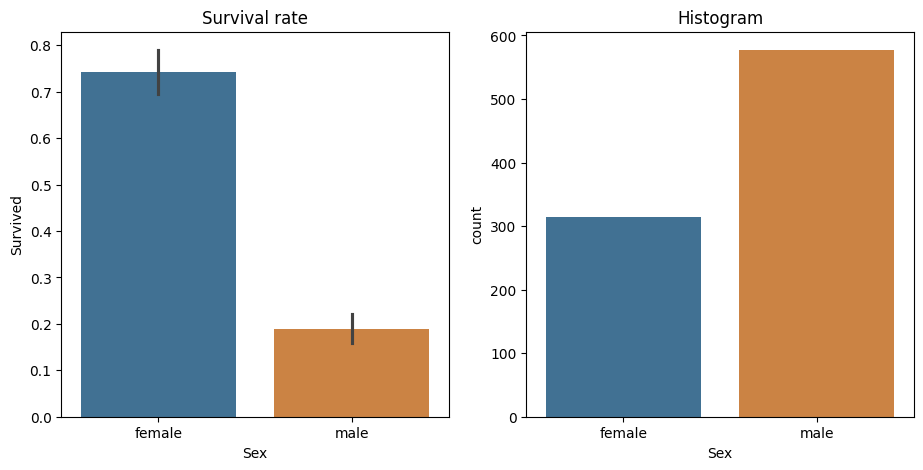

In [52]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0], hue="Sex", palette=["#3374a1","#e1812d"]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1], hue="Sex", palette=["#3374a1","#e1812d"]).set(title="Histogram");

Here we see that (on the left) if we split the data into males and females, we'd have groups that have very different survival rates: >70% for females, and <20% for males. We can also see (on the right) that the split would be reasonably even, with over 300 passengers (out of around 900) in each group.

We could create a very simple "model" which simply says that all females survive, and no males do. To do so, we better first split our data into a training and validation set, to see how accurate this approach turns out to be:

In [8]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

(In the previous step we also replaced the categorical variables with their integer codes, since some of the models we'll be building in a moment require that.)

Now we can create our independent variables (the `x` variables) and dependent (the `y` variable):

In [9]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

Here's the predictions for our extremely simple model, where `female` is coded as `0`:

In [10]:
preds = val_xs.Sex==0

We'll use mean absolute error to measure how good this model is:

In [11]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

np.float64(0.21524663677130046)

Alternatively, we could try splitting on a continuous column. We have to use a somewhat different chart to see how this might work -- here's an example of how we could look at `LogFare`:

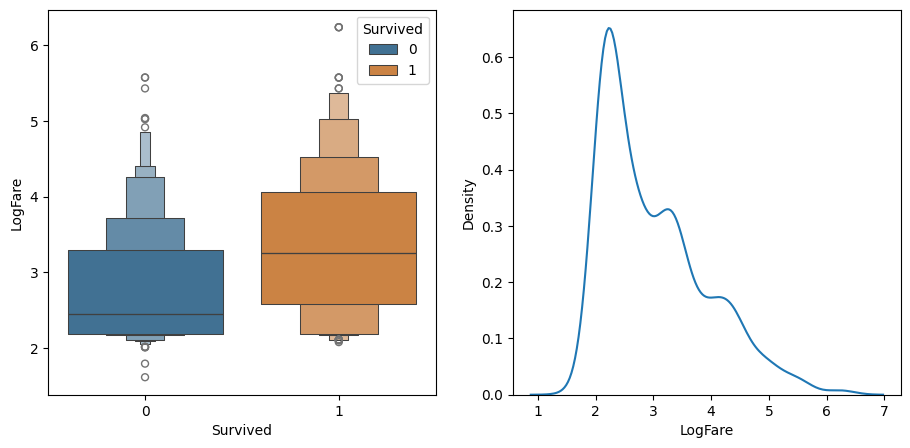

In [56]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0], hue=dep, palette=["#3374a1","#e1812d"])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

The [boxenplot](https://seaborn.pydata.org/generated/seaborn.boxenplot.html) above shows quantiles of `LogFare` for each group of `Survived==0` and `Survived==1`. It shows that the average `LogFare` for passengers that didn't survive is around `2.5`, and for those that did it's around `3.2`. So it seems that people that paid more for their tickets were more likely to get put on a lifeboat.

Let's create a simple model based on this observation:

In [13]:
preds = val_xs.LogFare>2.7

...and test it out:

In [14]:
mean_absolute_error(val_y, preds)

np.float64(0.336322869955157)

This is quite a bit less accurate than our model that used `Sex` as the single binary split.

Ideally, we'd like some way to try more columns and breakpoints more easily. We could create a function that returns how good our model is, in order to more quickly try out a few different splits. We'll create a `score` function to do this. Instead of returning the mean absolute error, we'll calculate a measure of *impurity* -- that is, how much the binary split creates two groups where the rows in a group are each similar to each other, or dissimilar.

We can measure the similarity of rows inside a group by taking the standard deviation of the dependent variable. If it's higher, then it means the rows are more different to each other. We'll then multiply this by the number of rows, since a bigger group as more impact than a smaller group:

In [15]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Now we've got that written, we can calculate the score for a split by adding up the scores for the "left hand side" (lhs) and "right hand side" (rhs):

In [16]:
    
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

For instance, here's the impurity score for the split on `Sex`:

In [17]:
score(trn_xs["Sex"], trn_y, 0.5)

np.float64(0.40787530982063946)

...and for `LogFare`:

In [18]:
score(trn_xs["LogFare"], trn_y, 2.7)

np.float64(0.47180873952099694)

As we'd expect from our earlier tests, `Sex` appears to be a better split.

To make it easier to find the best binary split, we can create a simple interactive tool (note that this only works in Kaggle if you click "Copy and Edit" in the top right to open the notebook editor):

In [19]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

Try selecting different columns and split points using the dropdown and slider above. What splits can you find that increase the purity of the data?

We can do the same thing for the categorical variables:

In [20]:
interact(nm=cats, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=2,…

That works well enough, but it's rather slow and fiddly. Perhaps we could get the computer to automatically find the best split point for a column for us? For example, to find the best split point for `age` we'd first need to make a list of all the possible split points (i.e all the unique values of that field)...:

In [21]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

...and find which index of those values is where `score()` is the lowest:

In [22]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

np.float64(6.0)

Based on this, it looks like, for instance, that for the `Age` column, `6` is the optimal cutoff according to our training set.

We can write a little function that implements this idea:

In [23]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(np.float64(6.0), np.float64(0.478316717508991))

Let's try all the columns:

In [24]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (np.int8(0), np.float64(0.40787530982063946)),
 'Embarked': (np.int8(0), np.float64(0.47883342573147836)),
 'Age': (np.float64(6.0), np.float64(0.478316717508991)),
 'SibSp': (np.int64(4), np.float64(0.4783740258817434)),
 'Parch': (np.int64(0), np.float64(0.4805296527841601)),
 'LogFare': (np.float64(2.4390808375825834), np.float64(0.4620823937736597)),
 'Pclass': (np.int64(2), np.float64(0.46048261885806596))}

According to this, `Sex<=0` is the best split we can use.

We've just re-invented the [OneR](https://link.springer.com/article/10.1023/A:1022631118932) classifier (or at least, a minor variant of it), which was found to be one of the most effective classifiers in real-world datasets, compared to the algorithms in use in 1993. Since it's so simple and surprisingly effective, it makes for a great *baseline* -- that is, a starting point that you can use to compare your more sophisticated models to.

We found earlier that out OneR rule had an error of around `0.215`, so we'll keep that in mind as we try out more sophisticated approaches.

## Creating a decision tree

How can we improve our OneR classifier, which predicts survival based only on `Sex`?

How about we take each of our two groups, `female` and `male`, and create one more binary split for each of them. That is: fine the single best split for females, and the single best split for males. To do this, all we have to do is repeat the previous section's steps, once for males, and once for females.

First, we'll remove `Sex` from the list of possible splits (since we've already used it, and there's only one possible split for that binary column), and create our two groups:

In [25]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

Now let's find the single best binary split for males...:

In [26]:
{o:min_col(males, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.3875581870410906)),
 'Age': (np.float64(6.0), np.float64(0.3739828371010595)),
 'SibSp': (np.int64(4), np.float64(0.3875864227586273)),
 'Parch': (np.int64(0), np.float64(0.3874704821461959)),
 'LogFare': (np.float64(2.803360380906535), np.float64(0.3804856231758151)),
 'Pclass': (np.int64(1), np.float64(0.38155442004360934))}

...and for females:

In [27]:
{o:min_col(females, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.4295252982857327)),
 'Age': (np.float64(50.0), np.float64(0.4225927658431649)),
 'SibSp': (np.int64(4), np.float64(0.42319212059713535)),
 'Parch': (np.int64(3), np.float64(0.4193314500446158)),
 'LogFare': (np.float64(4.256321678298823), np.float64(0.41350598332911376)),
 'Pclass': (np.int64(2), np.float64(0.3335388911567601))}

We can see that the best next binary split for males is `Age<=6`, and for females is `Pclass<=2`.

By adding these rules, we have created a *decision tree*, where our model will first check whether `Sex` is female or male, and depending on the result will then check either the above `Age` or `Pclass` rules, as appropriate. We could then repeat the process, creating new additional rules for each of the four groups we've now created.

Rather than writing that code manually, we can use `DecisionTreeClassifier`, from *sklearn*, which does exactly that for us:

In [28]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

One handy feature or this class is that it provides a function for drawing a tree representing the rules:

In [29]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

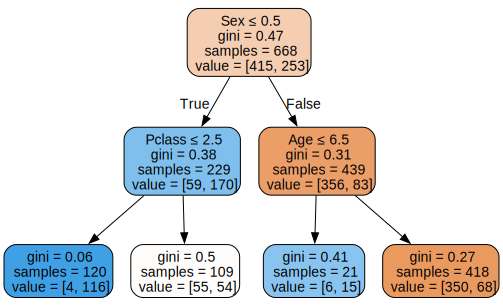

In [30]:
draw_tree(m, trn_xs, size=10)

We can see that it's found exactly the same splits as we did!

In this picture, the more orange nodes have a lower survival rate, and blue have higher survival. Each node shows how many rows ("*samples*") match that set of rules, and shows how many perish or survive ("*values*"). There's also something called "*gini*". That's another measure of impurity, and it's very similar to the `score()` we created earlier. It's defined as follows:

In [31]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

What this calculates is the probability that, if you pick two rows from a group, you'll get the same `Survived` result each time. If the group is all the same, the probability is `1.0`, and `0.0` if they're all different:

In [32]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(np.float64(0.3828350034484158), np.float64(0.3064437162277842))

Let's see how this model compares to our OneR version:

In [33]:
mean_absolute_error(val_y, m.predict(val_xs))

np.float64(0.2242152466367713)

It's a tiny bit worse. Since this is such a small dataset (we've only got around 200 rows in our validation set) this small difference isn't really meaningful. Perhaps we'll see better results if we create a bigger tree:

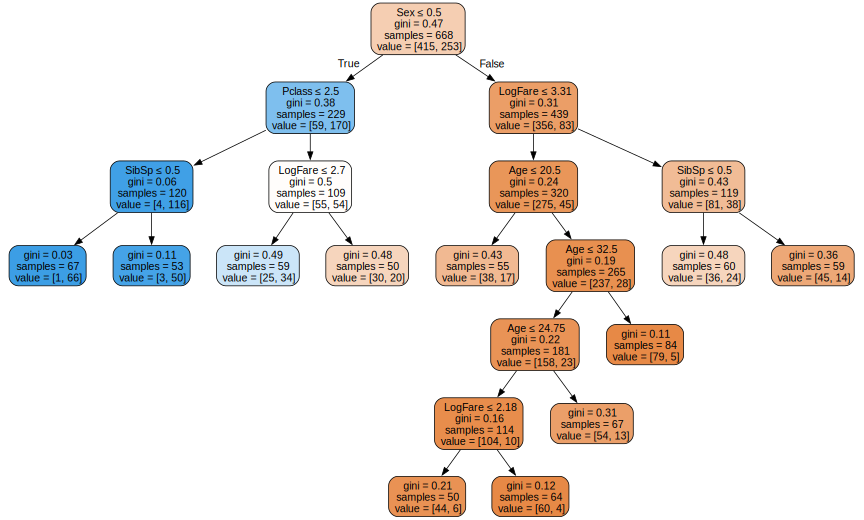

In [34]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [35]:
mean_absolute_error(val_y, m.predict(val_xs))

np.float64(0.18385650224215247)

It looks like this is an improvement, although again it's a bit hard to tell with small datasets like this. Let's try submitting it to Kaggle:

In [36]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds, suff):
    tst_df['Survived'] = preds
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'sub-{suff}.csv', index=False)

subm(m.predict(tst_xs), 'tree')

When I submitted this, I got a score of 0.765, which isn't as good as our linear models or most of our neural nets, but it's pretty close to those results.

Hopefully you can now see why we didn't really need to create dummy variables, but instead just converted the labels into numbers using some (potentially arbitary) ordering of categories. For instance, here's how the first few items of `Embarked` are labeled:

In [37]:
df.Embarked.head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

...resulting in these integer codes:

In [38]:
df.Embarked.cat.codes.head()

0    2
1    0
2    2
3    2
4    2
dtype: int8

So let's say we wanted to split into "C" in one group, vs "Q" or "S" in the other group. Then we just have to split on codes `<=0` (since `C` is mapped to category `0`). Note that if we wanted to split into "Q" in one group, we'd need to use two binary splits, first to separate "C" from "Q" and "S", and then a second split to separate "Q" from "S". For this reason, sometimes it can still be helpful to use dummy variables for categorical variables with few levels (like this one).

In practice, I often use dummy variables for <4 levels, and numeric codes for >=4 levels.

## The random forest

We can't make the decision tree much bigger than the example above, since some leaf nodes already have only 50 rows in them. That's not a lot of data to make a prediction.

So how could we use bigger trees? One big insight came from Leo Breiman: what if we create lots of bigger trees, and take the average of their predictions? Taking the average prediction of a bunch of models in this way is known as [bagging](https://link.springer.com/article/10.1007/BF00058655).

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value -- that's because the average of lots of uncorrelated random errors is zero. That's quite an amazing insight!

One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data. Here's how we can create a tree on a random subset of the data:

In [39]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

Now we can create as many trees as we want:

In [40]:
trees = [get_tree() for t in range(100)]

Our prediction will be the average of these trees' predictions:

In [41]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

np.float64(0.22748878923766816)

This is nearly identical to what `sklearn`'s `RandomForestClassifier` does. The main extra piece in a "real" random forest is that as well as choosing a random sample of data for each tree, it also picks a random subset of columns for each split. Here's how we repeat the above process with a random forest:

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

np.float64(0.18834080717488788)

We can submit that to Kaggle too:

In [43]:
subm(rf.predict(tst_xs), 'rf')

I found that gave nearly an identical result as our single tree (which, in turn, was slightly lower than our linear and neural net models in the previous notebook).

One particularly nice feature of random forests is they can tell us which independent variables were the most important in the model, using `feature_importances_`:

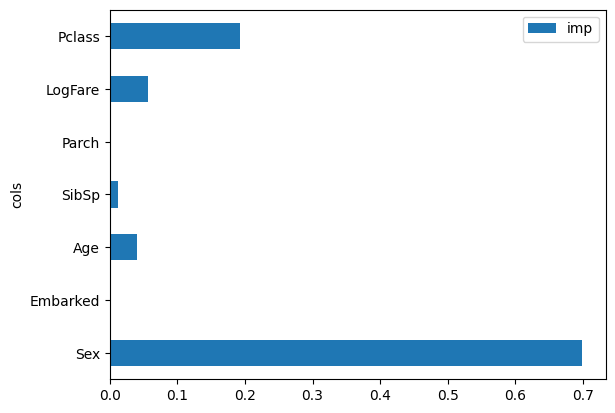

In [44]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

We can see that `Sex` is by far the most important predictor, with `Pclass` a distant second, and `LogFare` and `Age` behind that. In datasets with many columns, I generally recommend creating a feature importance plot as soon as possible, in order to find which columns are worth studying more closely. (Note also that we didn't really need to take the `log()` of `Fare`, since random forests only care about order, and `log()` doesn't change the order -- we only did it to make our graphs earlier easier to read.)

For details about deriving and understanding feature importances, and the many other important diagnostic tools provided by random forests, take a look at [chapter 8](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb) of [our book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527).

## Conclusion

So what can we take away from all this?

I think the first thing I'd note from this is that, clearly, more complex models aren't always better. Our "OneR" model, consisting of a single binary split, was nearly as good as our more complex models. Perhaps in practice a simple model like this might be much easier to use, and could be worth considering. Our random forest wasn't an improvement on the single decision tree at all.

So we should always be careful to benchmark simple models, as see if they're good enough for our needs. In practice, you will often find that simple models will have trouble providing adequate accuracy for more complex tasks, such as recommendation systems, NLP, computer vision, or multivariate time series. But there's no need to guess -- it's so easy to try a few different models, there's no reason not to give the simpler ones a go too!

Another thing I think we can take away is that random forests aren't actually that complicated at all. We were able to implement the key features of them in a notebook quite quickly. And they aren't sensitive to issues like normalization, interactions, or non-linear transformations, which make them extremely easy to work with, and hard to mess up!

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. (BTW, be sure you're looking at my [original notebook here](https://www.kaggle.com/jhoward/how-random-forests-work) when you do that, and are not on your own copy of it, otherwise your upvote won't get counted!) And if you have any questions or comments, please pop them below -- I read every comment I receive!